In [1]:
ls

Customer Lifetime Value.ipynb  LICENSE
HW1 clv_transactions.csv       README.md


In [59]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

## Background: Customer Lifetime Value
In marketing, customer lifetime value (CLV or often CLTV), lifetime customer value (LCV), or life-time value (LTV) is a prediction of the net profit attributed to the entire future relationship with a customer. Customer lifetime value can also be defined as the dollar value of a customer relationship, based on the present value of the projected future cash flows from the customer relationship. Customer lifetime value is an important concept in that it encourages firms to shift their focus from quarterly profits to the long-term health of their customer relationships. Customer lifetime value is an important number because it represents an upper limit on spending to acquire new customers. For this reason it is an important element in calculating payback of advertising spent in marketing mix modeling.

In [61]:
df = pd.read_csv("HW1 clv_transactions.csv", date_parser=True)

In [62]:
df.head()

,TransactionID,TransactionDate,CustomerID,Amount
0,1,9/4/2012,1,20.26
1,2,5/15/2012,2,10.87
2,3,5/23/2014,2,2.21
3,4,10/24/2014,2,10.48
4,5,10/13/2012,2,3.94


## About the Dataset
The dataset available is in CSV format and contains 4,200 transactions records. Each row in the dataset represent a single transaction. There are four columns in the dataset. 
- The TransactionID is a unique identifier of individual transactions. 
- The TransactionDate is the date of the transaction. 
- The CustomerID is the identifier of the customer who made the transaction. 
- And the Amount is the recorded amount of transaction in US dollars.


In [63]:
df.isna().sum() # 1. There are no missing values in the dataset

TransactionID      0
TransactionDate    0
CustomerID         0
Amount             0
dtype: int64

In [64]:
print("Min. Transaction Date: {}".format(df.TransactionDate.min())) # 2. Min Transaction Date
print("Max. Transaction Date: {}".format(df.TransactionDate.max())) # 2. Max Transaction Date

Min. Transaction Date: 1/1/2011
Max. Transaction Date: 9/9/2015


In [72]:
print("Count of unique customers: {}".format(len(set(df.CustomerID)))) # 3. Count of unique customers

Count of unique customers: 1000


In [66]:
print("*Descriptive Stats*:\nMin: {}, Max: {}, Var: {:.2f}, Std: {:.2f}".format(df.Amount.min(),df.Amount.max(), df.Amount.var(), df.Amount.std()))


*Descriptive Stats*:
Min: -1.0, Max: 2033.0, Var: 1499.54, Std: 38.72


/Users/sparshtekriwal/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



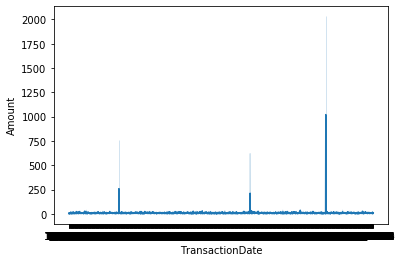

In [71]:
sns.lineplot(x="TransactionDate", y="Amount", data=df.sort_values(by=["TransactionDate"]))
plt.show()

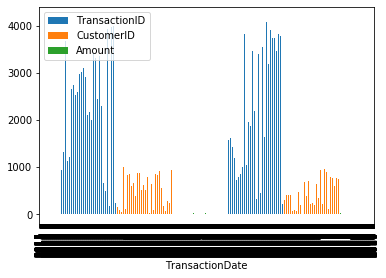

In [73]:
df.index = pd.to_datetime(df.TransactionDate).dt.year
#then sort index in descending order
df.sort_index(ascending = False , inplace = True)
df["Amount"].plot.bar()

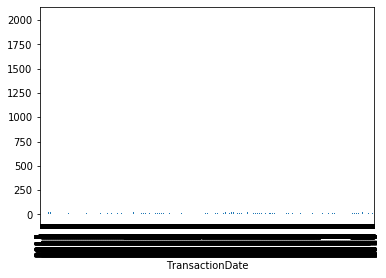

In [74]:
df["Amount"].plot.bar()